Does MMMmax correlate with annual 95th percentile?

In [1]:
import numpy as np
import xarray as xr
import extremespaper as ex
import viz
import mplRC
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cftime
import datetime as dt
import os
import glob
import matplotlib.cm as mcm
import warnings
import dask.array as da
mplRC.paperRC2()

warnings.filterwarnings(action='ignore',message='Mean of empty slice',category=RuntimeWarning)
warnings.filterwarnings(action='ignore',message='invalid value encountered in scalar divide',
                        category=RuntimeWarning)

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy39dc/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# plot AME versus annual percentile for each 3 scenarios (hist, 126, 370)

In [2]:
from extremespaper import *
ivar='spco2'
iscen='ESM4_historical_D1'
freq='daily'
yrspan=[1975,2014]
datar,mod_tnl,dims, sattrs,ds=loadSlab(ivar,freq,iscen,yrspan,chunksdef)

2025-05-19 04:22:36.403288
2025-05-19 04:22:36.654919
spco2 Pa


In [3]:
ds.spco2

<xarray.DataArray 'spco2' (time: 14600, lat: 180, lon: 360)> Size: 4GB
dask.array<concatenate, shape=(14600, 180, 360), dtype=float32, chunksize=(1825, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) object 117kB 1975-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    long_name:      Surface Aqueous Partial Pressure of CO2
    units:          Pa
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  surface_partial_pressure_of_carbon_dioxide_in_sea_water
    interp_method:  conserve_order1

In [4]:
ds.spco2.max().compute()*1e6/101325

<xarray.DataArray 'spco2' ()> Size: 8B
array(1859.82403683)

In [5]:
fday1=xr.open_dataset(ex.fNameAnnualExtremes(iscen,yrspan,'daily',ivar))

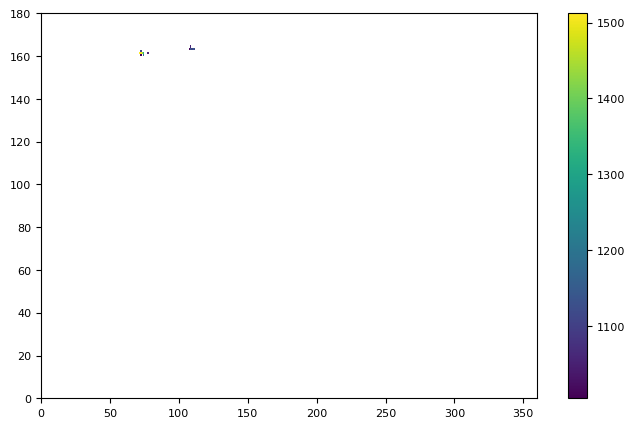

In [6]:
x=fday1.an_qt.sel(quantile=.95,year=2014)*1e6/101325
plt.pcolormesh(np.ma.masked_where(x<=1000,x))
plt.colorbar()

(0.0, 1000.0)

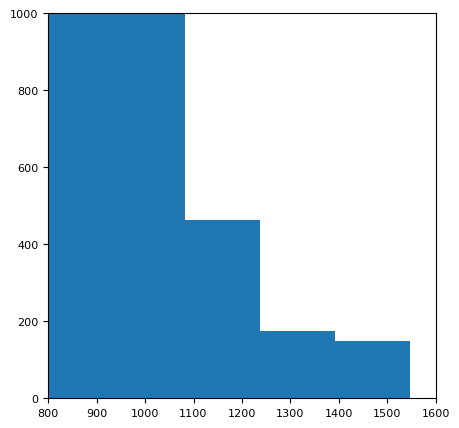

In [7]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.hist(np.ndarray.flatten(ds.spco2[-365:,:,:].values)*1e6/101325)
ax.set_xlim(800,1600)
ax.set_ylim(0,1000)

In [8]:
def _num2str(bb,ivar):
    if ivar in ['phos']:
        return f"{bb:.3f}"
    elif ivar in ['sos','chlos']:
        return f"{bb:.2f}"
    elif ivar in ['tos','apco2']:
        return f"{bb:.1f}"
    elif ivar in ['spco2','o2os','AOUos']:
        return f"{bb:3.0f}"
    else:
        return f"{bb:.3f}"
def _RMSE(obs,mod):
    # root mean square error, cannot include any NaN values
    return np.sqrt(np.sum((mod-obs)**2)/len(mod))
def _nMSE(obs,mod):
    # mean square error normalized to variance
    ix=~np.isnan(obs)&~np.isnan(mod)
    return np.sum((mod[ix]-obs[ix])**2)/len(mod[ix])/np.var(obs[ix])
def _nbias(obs,mod):
    ix=~np.isnan(obs)&~np.isnan(mod)
    return np.sum(mod[ix]-obs[ix])/len(mod[ix])/np.sqrt(np.var(obs[ix]))

In [9]:
vstrs={'tos':'SST ($^\circ$C)',
       'hplusos':'Surface H$^+$ (μM)',
       'omega_arag_0':'Surface $\Omega _{arag}$',
       'spco2':'Surface pCO$_2$ (μatm)'}
scenLabels={'ESM4_ssp126_D1':'SSP1-2.6','ESM4_ssp370_D1':'SSP3-7.0',
            'ESM4_ssp534-over_D1':'SSP5-3.4-OS',
           'ESM4_historical_D1':'Historical','126':'SSP1-2.6','245':'SSP2-4.5','370':'SSP3-7.0'}

0.42159526264719627 0.1934214724012067


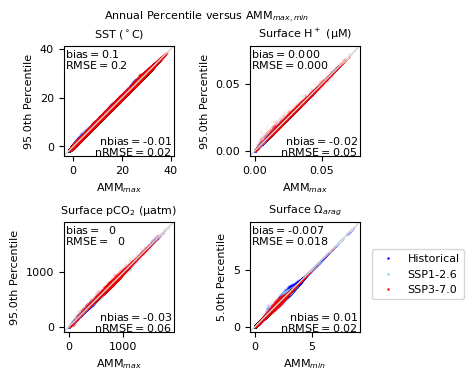

In [10]:
ivars=['tos','hplusos','spco2','omega_arag_0',]#'phos','o2_mean_100_600','thetao_50','hplus_50','ph_50','omega_arag_50','o2_50']
       
fig,ax=plt.subplots(3,2,figsize=(4,6),gridspec_kw={'hspace':.6,'wspace':.5})
ax=ax.flatten()
qq=.95
cols={'ESM4_historical_D1':'blue','ESM4_ssp126_D1':'lightskyblue', 'ESM4_ssp370_D1':'red'}
for ind,ivar in enumerate(ivars):
    A=1/101325*1e6 if ivar=='spco2' else 1
    xxs=[]
    yys=[]
    nMSEs=[]
    varis=[]
    nbs=[]
    for iscen1 in ('ESM4_historical_D1','ESM4_ssp126_D1', 'ESM4_ssp370_D1'):
        yrspan1=ex.dictScenDates[iscen1]
        qi=qq if ex.exdirs[ivar]>0 else np.round(1-qq,2)
        fday1=xr.open_dataset(ex.fNameAnnualExtremes(iscen1,yrspan1,'daily',ivar))
        fmon1=xr.open_dataset(glob.glob(ex.AMEpath(iscen1,['*','*'],
                                                'monthly',ivar,ex.exdirs[ivar]))[0])
        xx=fmon1[ivar].sel(year=slice(yrspan1[0],yrspan1[-1])).values.flatten()
        yy=fday1['an_qt'].sel(quantile=qi).values.flatten()
        xxs.append(xx.copy())
        yys.append(yy.copy())
        nMSEs.append(_nMSE(yy,xx))
        varis.append(np.nanvar(yy))
        nbs.append(_nbias(yy,xx))
        ax[ind].plot(A*xx.flatten(),A*yy.flatten(),'.',ms=.1,color=cols[iscen1],label=scenLabels[iscen1])
        fday1.close(); fmon1.close()
    xxs=np.concatenate(xxs).flatten()
    yys=np.concatenate(yys).flatten()
    iii=~np.isnan(xxs)&~np.isnan(yys)
    RMSE=_RMSE(xxs[iii],yys[iii])
    bias=np.mean(yys[iii]-xxs[iii])
    nRMSE=np.sqrt(np.mean(nMSEs))
    nbias=np.mean(nbs)
    if ivar=='spco2':print(RMSE,bias)
    ax[ind].text(.015, .885, 'RMSE$=$'+_num2str(RMSE,ivar), ha='left', va='top', 
                     transform=ax[ind].transAxes)
    ax[ind].text(.015, .985, 'bias$=$'+_num2str(bias,ivar), ha='left', va='top', 
                     transform=ax[ind].transAxes)
    ax[ind].text(.985, .095, 'nRMSE$=$'+f"{nRMSE:.2f}", ha='right', va='top', 
                     transform=ax[ind].transAxes)
    ax[ind].text(.985, .195, 'nbias$=$'+f"{nbias:.2f}", ha='right', va='top', 
                     transform=ax[ind].transAxes)
    if ex.exdirs[ivar]>0:
        ax[ind].set_xlabel('AMM$_{max}$')
    else:
        ax[ind].set_xlabel('AMM$_{min}$')
    ax[ind].set_ylabel(f'{qi*100}th Percentile')
    ax[ind].set_title(vstrs[ivar])
    viz.squareax(ax[ind])
ax[ind].legend(loc=1,bbox_to_anchor=[2,.8],markerscale=15)
while ind<len(ax)-1:
    ind=ind+1
    ax[ind].remove()
fig.suptitle('Annual Percentile versus AMM$_{max,min}$ ',y=.94);
fig.savefig(f'percentileVsMMMm.png',
            dpi=300,bbox_inches='tight')

In [11]:
1-1/np.pi*np.arccos(1/30*(365/(2*np.pi)*np.sin(2*np.pi*15/365)-365/(2*np.pi)*np.sin(-2*np.pi*15/365)))

0.9525817580498872

In [12]:
1-1/np.pi*np.arccos(1/30*(365/(2*np.pi)*np.sin(2*np.pi*30/365)))

0.9053759549517422

In [13]:
1/30*(365/(2*np.pi)*np.sin(2*np.pi*15/365)-365/(2*np.pi)*np.sin(-2*np.pi*15/365))

0.988924652711921

In [14]:
1/30*(365/(2*np.pi)*np.sin(2*np.pi*30/365))

0.9561396382948792

In [15]:
F=1/30*1/30*365/(2*np.pi)*(-1)*(-1)*365/(2*np.pi)*(\
     np.cos(2*np.pi/365*(30-30))-np.cos(2*np.pi/365*(0-30))\
     -np.cos(2*np.pi/365*(30-0))+np.cos(2*np.pi/365*(0-0)))

In [16]:
F

0.9779719687413937

In [17]:
1-1/np.pi*np.arccos(F)

0.9330649753807102

Look at what ptile has lowest RMSE and bias for each variable

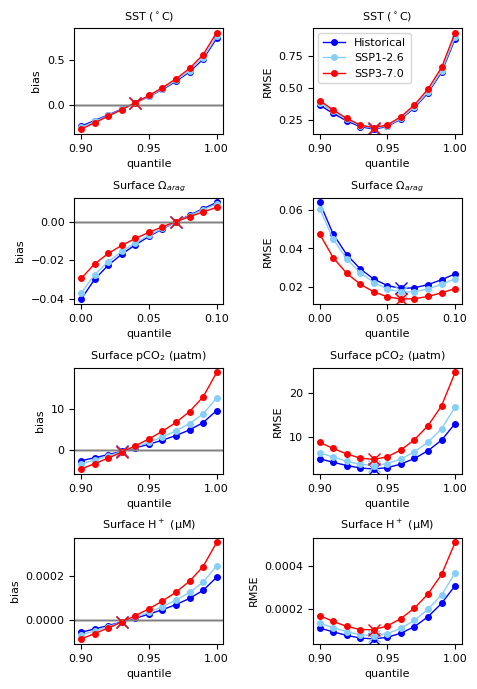

In [18]:
ivars=['tos','omega_arag_0','spco2','hplusos',]#'phos','o2_mean_100_600','thetao_50','hplus_50','ph_50','omega_arag_50','o2_50']
       
fig,ax=plt.subplots(4,2,figsize=(5,8),gridspec_kw={'hspace':.6,'wspace':.6})
qlist=np.array([.9,.91,.92,.93,.94,.95,.96,.97,.98,.99,1])
#cols={'ESM4_historical_D1':'purple','ESM4_ssp126_D1':'red', 'ESM4_ssp370_D1':'blue'}
for ind,ivar in enumerate(ivars):
    A=1/101325*1e6 if ivar=='spco2' else 1
    for iscen1 in ('ESM4_historical_D1','ESM4_ssp126_D1', 'ESM4_ssp370_D1'):
        RMSEs=[]
        biass=[]
        for qq in qlist:
            xxs=[]
            yys=[]
            yrspan1=ex.dictScenDates[iscen1]
            qi=qq if ex.exdirs[ivar]>0 else np.round(1-qq,2)
            fday1=xr.open_dataset(ex.fNameAnnualExtremes(iscen1,yrspan1,'daily',ivar))
            fmon1=xr.open_dataset(glob.glob(ex.AMEpath(iscen1,['*','*'],
                                                    'monthly',ivar,ex.exdirs[ivar]))[0])
            xx=fmon1[ivar].sel(year=slice(yrspan1[0],yrspan1[-1])).values.flatten()*A
            yy=fday1['an_qt'].sel(quantile=qi).values.flatten()*A
            xxs.append(xx.copy())
            yys.append(yy.copy())
            fday1.close(); fmon1.close()
            xxs=np.concatenate(xxs).flatten()
            yys=np.concatenate(yys).flatten()
            iii=~np.isnan(xxs)&~np.isnan(yys)
            RMSEs.append(_RMSE(xxs[iii],yys[iii]))
            biass.append(np.mean(yys[iii]-xxs[iii]))
        qs=qlist if ex.exdirs[ivar]>0 else np.array([np.round(1-qq,2) for qq in qlist])
        ax[ind,0].plot(qs,biass,'.-',color=cols[iscen1])
        ax[ind,0].axhline(0,linestyle='-',color='gray')
        ax[ind,1].plot(qs,RMSEs,'.-',color=cols[iscen1],label=scenLabels[iscen1])
        ib=np.argmin(np.abs(biass))
        ir=np.argmin(RMSEs)
        ax[ind,0].plot(qs[ib],biass[ib],'x',color=cols[iscen1])
        ax[ind,1].plot(qs[ir],RMSEs[ir],'x',color=cols[iscen1])
    ax[ind,0].set_xlabel('quantile')
    ax[ind,1].set_xlabel('quantile')
    ax[ind,0].set_ylabel('bias')
    ax[ind,1].set_ylabel('RMSE')
    ax[ind,0].set_title(vstrs[ivar])
    ax[ind,1].set_title(vstrs[ivar])
ax[0,1].legend()
fig.savefig(f'ptileMatch.png',
            dpi=300,bbox_inches='tight')

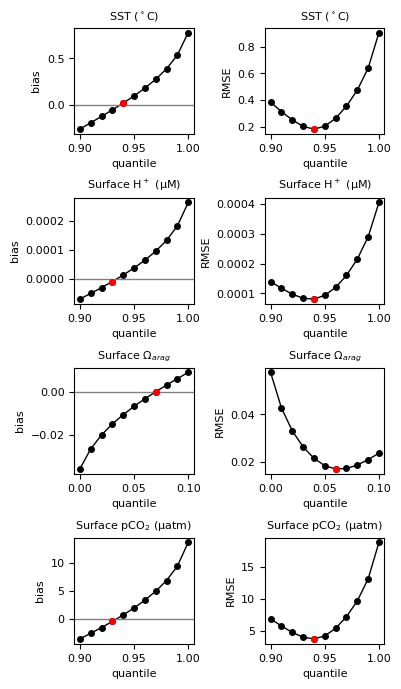

In [19]:
ivars=['tos','hplusos','omega_arag_0','spco2',]#'phos','o2_mean_100_600','thetao_50','hplus_50','ph_50','omega_arag_50','o2_50']
       
fig,ax=plt.subplots(4,2,figsize=(4,8),gridspec_kw={'hspace':.6,'wspace':.6})
qlist=np.array([.9,.91,.92,.93,.94,.95,.96,.97,.98,.99,1])
cols={'ESM4_historical_D1':'purple','ESM4_ssp126_D1':'red', 'ESM4_ssp370_D1':'blue'}
for ind,ivar in enumerate(ivars):
    A=1/101325*1e6 if ivar=='spco2' else 1
    RMSEs=[]
    biass=[]
    for qq in qlist:
        xxs=[]
        yys=[]
        for iscen1 in ('ESM4_historical_D1','ESM4_ssp126_D1', 'ESM4_ssp370_D1'):
            yrspan1=ex.dictScenDates[iscen1]
            qi=qq if ex.exdirs[ivar]>0 else np.round(1-qq,2)
            fday1=xr.open_dataset(ex.fNameAnnualExtremes(iscen1,yrspan1,'daily',ivar))
            fmon1=xr.open_dataset(glob.glob(ex.AMEpath(iscen1,['*','*'],
                                                    'monthly',ivar,ex.exdirs[ivar]))[0])
            xx=fmon1[ivar].sel(year=slice(yrspan1[0],yrspan1[-1])).values.flatten()*A
            yy=fday1['an_qt'].sel(quantile=qi).values.flatten()*A
            xxs.append(xx.copy())
            yys.append(yy.copy())
            fday1.close(); fmon1.close()
        xxs=np.concatenate(xxs).flatten()
        yys=np.concatenate(yys).flatten()
        iii=~np.isnan(xxs)&~np.isnan(yys)
        RMSEs.append(_RMSE(xxs[iii],yys[iii]))
        biass.append(np.mean(yys[iii]-xxs[iii]))
    qs=qlist if ex.exdirs[ivar]>0 else np.array([np.round(1-qq,2) for qq in qlist])
    ax[ind,0].plot(qs,biass,'k.-')
    ax[ind,0].axhline(0,linestyle='-',color='gray')
    ax[ind,1].plot(qs,RMSEs,'k.-')
    ib=np.argmin(np.abs(biass))
    ir=np.argmin(RMSEs)
    ax[ind,0].plot(qs[ib],biass[ib],'r.')
    ax[ind,1].plot(qs[ir],RMSEs[ir],'r.')
    ax[ind,0].set_xlabel('quantile')
    ax[ind,1].set_xlabel('quantile')
    ax[ind,0].set_ylabel('bias')
    ax[ind,1].set_ylabel('RMSE')
    ax[ind,0].set_title(vstrs[ivar])
    ax[ind,1].set_title(vstrs[ivar])
# fig.savefig(f'ptileMatch.png',
#             dpi=300,bbox_inches='tight')